# Filter Experiments

## Imports

In [69]:
%matplotlib inline

import math
import numpy as np
import scipy as sp
import scipy.constants as const

from scipy import signal
from scipy.signal import butter, firwin, lfilter, freqz
from scipy.signal import freqz

## Constants & Global Variables

In [70]:
input_data_directory = "data"
output_data_directory = "out"

sample_rate = 44100
tone_duration = 0.01
tone_frequency0 = 2000
tone_frequency1 = 6000

def normalize_data(data):
    return data/0x7FFF

def sinwave_tone(frequency, duration, sample_rate):
    return np.sin(2 * math.pi * np.arange(math.ceil(sample_rate * duration)) * frequency / sample_rate) * 0x7FFF

def chirp_tone(frequency0, frequency1, duration, phase0=0, sample_rate=44100):
    num_samples = math.ceil(sample_rate * duration);
    k = (frequency1 - frequency0)/num_samples
    return np.sin(phase0+2*math.pi*(np.arange(num_samples)*frequency0/sample_rate+k/2*np.arange(num_samples)**2/sample_rate)) * 0x7FFF

## Generate Tone

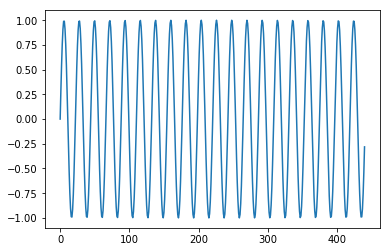

In [71]:
tone_data = sinwave_tone(tone_frequency0, tone_duration, sample_rate)
wavfile.write(input_data_directory+"/audio/tone.wav", sample_rate, tone_data.astype(np.int16))
tone_data = normalize_data(tone_data)

plt.figure()
plt.plot(tone_data)

## Visualize possible filters

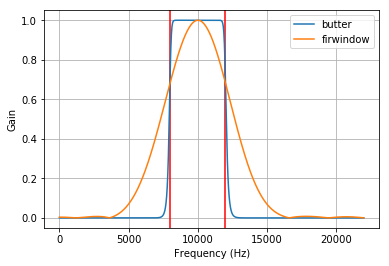

In [85]:
# Plot the frequency response for a few different filters and parameters.
plt.figure()
plt.clf()

low_cut_frequency = 8000
high_cut_frequency = 12000
filter_order = 17

plt.axvline(low_cut_frequency, color='red') # low cutoff frequency
plt.axvline(high_cut_frequency, color='red') # high cutoff frequency

nyquist_rate = sample_rate/2
b, a = butter(order, [low_cut_frequency/nyquist_rate, high_cut_frequency/nyquist_rate], btype='bandpass')
w, h = freqz(b, a)
plt.plot((sample_rate * 0.5 / np.pi) * w, abs(h), label="butter")

b = firwin(order+1, [low_cut_frequency, high_cut_frequency], pass_zero=False, nyq=nyquist_rate)
a = [1.0]
w, h = freqz(b)
plt.plot((nyquist_rate/np.pi)*w , abs(h), label="firwindow")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

